In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
experiment = "exp-dqn-dynasim-259200-1-4"
root_folder = "/Users/paola/OneDrive - Universiteit Antwerpen/DAEMON/Dynasim/experiments"
os.chdir(os.path.join(root_folder, experiment))
train_traces = experiment + ".traces"

test_traces = "exp-test"
exps = {}

# select the traces from last experiment
for folder_name in os.listdir('./'):
    if folder_name.startswith(test_traces):
        exp_nb = int(folder_name.split("-")[-1])
        exps[exp_nb] = folder_name

if exps:
    nb_exp = list(exps.keys())
    nb_exp.sort()
    last_exp = nb_exp[-1]
else:
    print("No test results found")


test_results_dir = exps[last_exp] # needed
trace = test_results_dir.split("-")
trace.pop(1)
test_traces = "-".join(trace) + ".traces" # needed
test_traces

'exp-dqn-dynasim-172800-1-0.traces'

In [4]:
# Parse Results
# initialize dicts
modes = ["training", "testing"]
jobs = {key: [] for key in modes}
ms = {key: [] for key in modes}
cpu_usage = {key: [] for key in modes}
overflow = {key: [] for key in modes}
peak_latency = {key: [] for key in modes}
avg_latency = {key: [] for key in modes}
action = {key: [] for key in modes}
reward = {key: [] for key in modes}
cum_reward = {key: [] for key in modes}
reward_cum = {key: [] for key in modes}
current_timesteps = {key: [] for key in modes}
restarts_per_episode = {key: {} for key in modes}
timesteps = {}

act_2_meaning = {
    0: "increase",
    1: "decrease",
    2: "nothing"
}
       # Parse results
for mode in modes:
    if mode == "training":
        # open file for training traces
        traces_filename = train_traces
    else:
        # open file for training traces
        traces_filename = os.path.join(test_results_dir, test_traces)
    print(traces_filename)
    with open(traces_filename) as f:
        current_step = 0
        cumulative_reward = 0
        for line in f:
            line = line.rstrip().split("|")[-1]
            if line.startswith("Mode"):
                mode = line.split(":")[-1].rstrip().split()[0]
                timesteps[mode] = int(line.split(":")[-1].rstrip().split()[2])
                if mode == "training": timesteps["base"] = int(line.split(":")[-1].rstrip().split()[-2])
            if line.startswith("Step"):
                current_step = int(line.split(":")[-1].rstrip())
                current_timesteps[mode].append(current_step)
            if line.startswith("Environment Reset"):
                if not restarts_per_episode[mode]:
                    # dict is empty
                    restarts_per_episode[mode] = []
                if current_step != 0:
                    # if it is not the first step
                    restarts_per_episode[mode].append(current_step)
                    cum_reward[mode].append(cumulative_reward)
            if line.startswith("Traffic"):
                jobs[mode].append(int(line.split(":")[-1].rstrip()))
            if line.startswith("MS"):
                ms[mode].append(int(line.split(":")[-1].rstrip()))
            if line.startswith("Cpu"):
                cpu_usage[mode].append(float(line.split(":")[-1].rstrip()))
            if line.startswith("Overflow"):
                overflow[mode].append(float(line.split(":")[-1].rstrip()))
            if line.startswith("Peak Latency"):
                peak_latency[mode].append(float(line.split(":")[-1].rstrip()))
            if line.startswith("Avg Latency"):
                avg_latency[mode].append(float(line.split(":")[-1].rstrip()))
            if line.startswith("Reward"):
                reward[mode].append(float(line.split(":")[-1].rstrip()))
            if line.startswith("Cum Reward"):
                cumulative_reward = float(line.split(":")[-1].rstrip())
                reward_cum[mode].append(float(line.split(":")[-1].rstrip()))
            if line.startswith("Action"):
                line = line.split(",")[0]
                action[mode].append(act_2_meaning[int(line.split(":")[-1].rstrip())])
            if line.startswith("Agent end training"):
                print(line)
    if mode == "training":
        cum_reward["training"].append(cumulative_reward)
        restarts_per_episode["training"].append(current_step)
    else:
        cum_reward["testing"].append(cumulative_reward)
        restarts_per_episode["testing"].append(current_step)

exp-dqn-dynasim-259200-1-4.traces
Agent end training. Elapsed time: 12503.357993841171
exp-test-dqn-dynasim-172800-1-0/exp-dqn-dynasim-172800-1-0.traces


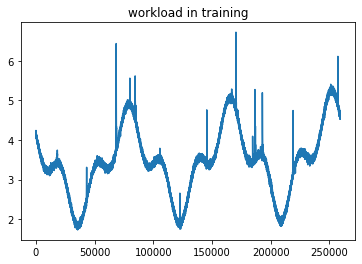

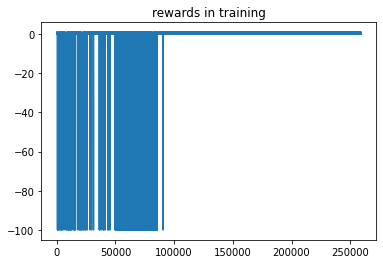

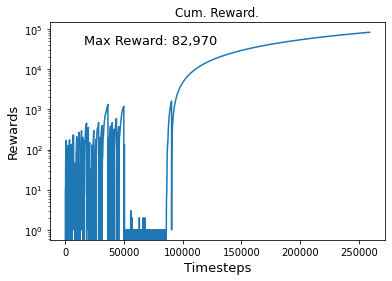

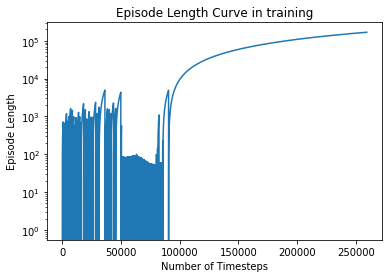

In [5]:
# train figures
fontsize=13
# --------------- workload ------------------------------
plt.figure()
plt.plot(np.array(jobs["training"])/300., label="workload")
plt.title("workload in training")
plt.savefig('./workload_train.png', dpi=300)
plt.show()

# ---------------------------- immediate rewards  ---------------------------------------------------------
plt.figure()
plt.plot(np.array(reward["training"]))
plt.title("rewards in training")
plt.savefig('./rewards_train.png', dpi=300)
plt.show()

# ---------------------------- cumulative rewards (own) ---------------------------------------------------------
fig, ax = plt.subplots()
ax.plot(np.array(reward_cum["training"]))
ax.set_yscale('log')
ax.set_xlabel('Timesteps', fontsize=fontsize)
ax.set_ylabel('Rewards', fontsize=fontsize)
max_reward = int(max(np.array(reward_cum['training'])))
txt = f"Max Reward: {max_reward:,}"
ax.text(0.1, 0.9, txt, transform=ax.transAxes, fontsize=fontsize)
ax.set_title("Cum. Reward.")
plt.savefig('./reward_cum_train.png', dpi=300)
plt.show()

# ---------------------------- episode length (own)  ---------------------------------------------------------
plt.figure()
plt.plot(np.array(current_timesteps["training"]))
plt.yscale('log')
plt.xlabel('Number of Timesteps')
plt.ylabel('Episode Length')
plt.title("Episode Length Curve in training")
plt.savefig('./episode_len_train.png', dpi=300)
plt.show()

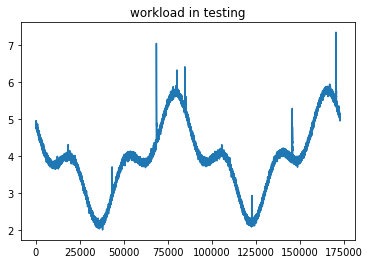

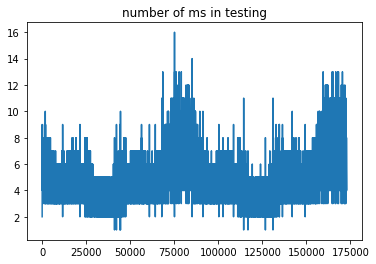

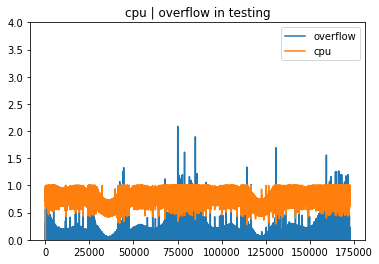

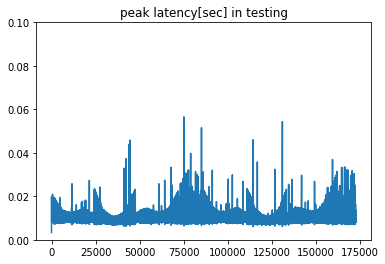

In [6]:
# test figures
# --------------- workload ------------------------------
plt.figure()
plt.plot(np.array(jobs["testing"])/300.)
plt.title("workload in testing")
plt.savefig('./workload_test.png', dpi=300)
plt.show()

# --------------- num ms ------------------------------
plt.figure()
plt.plot(np.array(ms["testing"]))
plt.title("number of ms in testing")
plt.savefig('./ms_test.png', dpi=300)
plt.show()

# --------------- cpu|overflow ------------------------------
plt.figure()
plt.plot(np.array(overflow["testing"]), label="overflow")
plt.plot(np.array(cpu_usage["testing"]), label="cpu")
plt.ylim([0, 4])
plt.title("cpu | overflow in testing")
plt.legend()
plt.savefig('./cpu_overflow_test.png', dpi=300)
plt.show()

# --------------- peak latency ------------------------------
plt.figure()
plt.plot(np.array(peak_latency["testing"]))
plt.ylim([0, 0.1])
plt.title("peak latency[sec] in testing")
plt.savefig('./peak_latency_test.png', dpi=300)
plt.show()

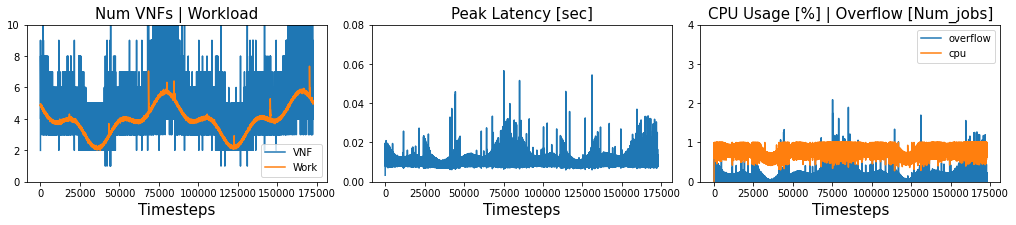

In [7]:
# plots for paper
fontsize=15

fig = plt.figure(constrained_layout=True, figsize=(14,3))
gs = GridSpec(1, 3, figure=fig)
# 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.array(ms["testing"]), label='VNF')
ax1.plot(np.array(jobs["testing"])/300., label='Work')
ax1.set_ylim([0, 10])
ax1.set_xlabel('Timesteps', fontsize=fontsize)
ax1.set_title('Num VNFs | Workload', fontsize=fontsize)
ax1.legend()
# 
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(np.array(peak_latency["testing"]), label='peak_lat')
ax2.set_ylim([0, 0.08])
ax2.set_xlabel('Timesteps', fontsize=fontsize)
ax2.set_title('Peak Latency [sec]', fontsize=fontsize)
# 
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(np.array(overflow["testing"]), label='overflow')
ax3.plot(np.array(cpu_usage["testing"]), label='cpu')
ax3.set_ylim([0, 4])
ax3.set_xlabel('Timesteps', fontsize=fontsize)
ax3.set_title('CPU Usage [%] | Overflow [Num_jobs]', fontsize=fontsize)
ax3.legend()

plt.savefig('./results_rl_paper.png', dpi=300)
plt.show()

In [8]:
# statistics
df = pd.DataFrame({'num_ms': ms["testing"], 'peak_latency': peak_latency["testing"]})
print(df.describe())

              num_ms   peak_latency
count  172801.000000  172801.000000
mean        4.766633       0.009787
std         1.346878       0.002137
min         1.000000       0.003330
25%         4.000000       0.008790
50%         5.000000       0.009240
75%         5.000000       0.009980
max        16.000000       0.056540


In [9]:
# SLO Violations
max_latency = 0.024
peak = np.array(peak_latency["testing"])
total_slo_measurements = len(peak)
peak = peak[peak>max_latency]
total_slo_violations = len(peak)
print(f"Total of SLO violations: {total_slo_violations}")
perc_slo_violations = total_slo_violations/total_slo_measurements
print(f"Percentage of SLO violations: {perc_slo_violations:2.2%}")

Total of SLO violations: 322
Percentage of SLO violations: 0.19%


In [ ]:
df.loc[df['peak_latency'] > max_latency, 'slo_violation'] = 1.0
df.loc[df['peak_latency'] <= max_latency, 'slo_violation'] = 0.0
df[df.slo_violation==1.0].count()

In [ ]:
df['counter'] = df['slo_violation'].diff().ne(0).cumsum()
df['counter']

In [ ]:
df2 = df.groupby('counter')['slo_violation'].min().to_frame(name='value').join(df.groupby('counter')['slo_violation'].count().rename('number'))
max_consec0 = df2[df2['value']==0]['number'].tolist()
max_consec1 = df2[df2['value']==1]['number'].tolist()
# max_consec1

In [ ]:
import matplotlib.pyplot as plt
import numpy

# data = numpy.random.randn(1000)
# print("The data is-",data)
sorted_random_data = numpy.sort(max_consec1)
p = 1. * numpy.arange(len(sorted_random_data)) / float(len(sorted_random_data) - 1)
# print("The CDF result is-",p)

fig = plt.figure()
fig.suptitle('CDF of data points')
ax2 = fig.add_subplot(111)
ax2.plot(sorted_random_data, p)
ax2.set_xlabel('sorted_random_data')
ax2.set_ylabel('p')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
  
# No of Data points
N = 500
  
# initializing random values
# data = np.random.randn(N)
  
# getting data of the histogram
count, bins_count = np.histogram(max_consec1, bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()